In [1]:
# modules
import os
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import dask
import dask.array
from scipy import ndimage
from skimage import filters, feature, io
from skimage.morphology import disk,ball
import sys
from itertools import combinations_with_replacement
import pickle
import imageio
import json
from dask.distributed import Client, LocalCluster
import socket
import subprocess
import gc
import h5py
import logging
import warnings
import datetime
warnings.filterwarnings('ignore')


from dask import config as cfg
# cfg.set({'distributed.scheduler.worker-ttl': None, # Workaround so that dask does not kill workers while they are busy fetching data: https://dask.discourse.group/t/dask-workers-killed-because-of-heartbeat-fail/856, maybe this helps: https://www.youtube.com/watch?v=vF2VItVU5zg?
#         'distributed.scheduler.transition-log-length': 100, #potential workaround for ballooning scheduler memory https://baumgartner.io/posts/how-to-reduce-memory-usage-of-dask-scheduler/
#          'distributed.scheduler.events-log-length': 100
#         }) seems to be outdate

cfg.set({'distributed.scheduler.worker-ttl': None, # Workaround so that dask does not kill workers while they are busy fetching data: https://dask.discourse.group/t/dask-workers-killed-because-of-heartbeat-fail/856, maybe this helps: https://www.youtube.com/watch?v=vF2VItVU5zg?
        'distributed.admin.low-level-log-length': 100 #potential workaround for ballooning scheduler memory https://baumgartner.io/posts/how-to-reduce-memory-usage-of-dask-scheduler/
        }) # still relevant ?

#paths
host = socket.gethostname()
if host[:3] == 'hpc': # experiment with the wood data on the big ESRF cluster node
    temppath = '/tmp_14_days/robert'
    training_path = '/home/esrf/rofische/data_ihma664/PROCESSED_DATA/TOMCAT/wood'
    pytrainpath = '/home/esrf/rofische/lib/pytrainseg'
    memlim = '700GB'

else:
    print('host '+host+' currently not supported')
    
    
    
# get the ML functions, TODO: make a library once it works/is in a stable state

cwd = os.getcwd()
os.chdir(pytrainpath)
from feature_stack import image_filter
import training as tfs
from training import training

pytrain_git_sha = subprocess.check_output(['git', 'rev-parse', '--short', 'HEAD']).decode().strip()
os.chdir(cwd)



### functionalities for interactive training

In [2]:
from ipywidgets import Image
from ipywidgets import ColorPicker, IntSlider, link, AppLayout, HBox
from ipycanvas import  hold_canvas,  MultiCanvas #RoughCanvas,Canvas,

def on_mouse_down(x, y):
    global drawing
    global position
    global shape
    drawing = True
    position = (x, y)
    shape = [position]

def on_mouse_move(x, y):
    global drawing
    global position
    global shape
    if not drawing:
        return
    with hold_canvas():
        canvas.stroke_line(position[0], position[1], x, y)
        position = (x, y)
    shape.append(position)

def on_mouse_up(x, y, fill=False):
    global drawing
    global positiondu
    global shape
    drawing = False
    with hold_canvas():
        canvas.stroke_line(position[0], position[1], x, y)
        if fill:
            canvas.fill_polygon(shape)
    shape = []
    
def display_feature(i, TS, feat_stack):
    # print('selected '+TS.feature_names[i])
    im = feat_stack[:,:,i]
    im8 = im-im.min()
    im8 = im8/im8.max()*255
    return im8

### fire up dask, distributed Client currently not usable. No idea how not setting up dask affects the computation

In [3]:
dask.config.config['temporary-directory'] = temppath
def boot_client(dashboard_address=':35000', memory_limit = memlim, n_workers=2): # 2 workers appears to be the optimum, will still distribute over the full machine
    # tempfolder = temppath  #a big SSD is a major adavantage to allow spill to disk and still be efficient. large dataset might crash with too small SSD or be slow with normal HDD
# tempfolder = temppath_2
# dask.config.config['distributed']['worker']['memory']['recent-to-old-time'] = '200000s'

# here you have the option to use a virtual cluster or even slurm on ra (not attempted yet)
    cluster = LocalCluster(dashboard_address=dashboard_address, memory_limit = memory_limit, n_workers=n_workers, silence_logs=logging.ERROR) #settings optimised for mpc2959, play around if needed, if you know nothing else is using RAM then you can almost go to the limit
# # maybe less workers with more threads makes better use of shared memory 

# # scheduler_port = 'tcp://129.129.188.222:8786' #<-- if scheduler on mpc2959; scheduler on mpc2053 -> 'tcp://129.129.188.248:8786'
# # cluster = scheduler_port

    client = Client(cluster) #don't show warnings, too many seem to block execution
# # client.amm.start()
    print('Dashboard at '+client.dashboard_link)
    return client, cluster

def reboot_client(client, dashboard_address=':35000', memory_limit = memlim, n_workers=2):
    client.shutdown()
    cluster = LocalCluster(dashboard_address=dashboard_address, memory_limit = memory_limit, n_workers=n_workers, silence_logs=logging.ERROR)
    client = Client(cluster)
    return client

In [4]:
client, cluster = boot_client()

Dashboard at http://127.0.0.1:35000/status


## Data preparation

### let dask load the data

store data in a hdf5 (eg. xarray to .nc) as an entry 'image_data' containing a 4D array. There is potential in structuring the data on the disk (SSD recommended for fast data streaming)

In [5]:
sample ='T6_BS_05_wetting_4D_fast'
# imagepath = os.path.join(training_path, '01_'+sample+'_cropped.nc')
imagepath = os.path.join(training_path, '00_'+sample+'_cropped_4D_filtered_fixed.nc')

In [6]:
file = h5py.File(imagepath)

In [7]:
chunk_space = 64 # potential for optmisation by matching chunksize with planned image filter kernels and file structure on disk for fast data streaming
# chunks = (chunk_space,chunk_space,chunk_space,len(file['time']))
chunks = (chunk_space,chunk_space,chunk_space,len(file['timestep']))
da = dask.array.from_array(file['image_data'], chunks= chunks)

### get data into image filter class

In [8]:
# TODO: include this routine into pytrainseg

IF = image_filter(sigmas = [0,1,3,6]) #recommendation: pre-process before loading, i.e. as extra file on disk , preprocess_with_unsharp_mask=True
IF.data = da
shp = da.shape
shp_raw = shp

### prepare features
creates a dask graph with dependent calculations to allow on-demand and larger-than-memory calculation

In [9]:
IF.prepare()

In [10]:
IF.stack_features()

In [11]:
IF.feature_stack

dask.array<stack, shape=(1120, 1120, 1400, 120, 65), dtype=float64, chunksize=(64, 64, 64, 120, 1), chunktype=numpy.ndarray>

In [12]:
# uncomment if you want to reduce the feature stack
# IF.reduce_feature_stack(feature_names_to_use)

In [13]:
IF.make_xarray()

using full feature stack because
- reduced stack not calculated


## Training

### set up some objects

In [14]:
training_path_sample = os.path.join(training_path, sample)
if not os.path.exists(training_path_sample):
    os.mkdir(training_path_sample)

In [15]:
training_path_sample

'/home/esrf/rofische/data_ihma664/PROCESSED_DATA/TOMCAT/wood/T6_BS_05_wetting_4D_fast'

In [16]:
TS = training(training_path=training_path_sample)
TS.client = client
IF.client = client
TS.cluster = cluster
IF.cluster = cluster
TS.memlim = memlim
TS.n_workers = 2

There are existing training sets, run .train() if you want to use them:
label_image_x_1059_time_69_.tif
label_image_y_1002_time_40_.tif
label_image_y_342_time_2_.tif
label_image_y_352_time_74_.tif
label_image_y_3_time_108_.tif
label_image_y_554_time_89_.tif
label_image_y_632_time_113_.tif
label_image_y_731_time_3_.tif
label_image_y_837_time_60_.tif
label_image_y_887_time_43_.tif
label_image_y_922_time_15_.tif
label_image_z_1002_time_2_.tif
label_image_z_103_time_95_.tif
label_image_z_364_time_103_.tif
label_image_z_659_time_63_.tif
label_image_z_711_time_61_.tif
label_image_z_720_time_39_.tif
label_image_z_900_time_78_.tif


### give the feature stack to the training class

In [17]:
TS.feat_data = IF.feature_xarray

In [18]:
IF.combined_feature_names = list(IF.feature_names) + list(IF.feature_names_time_independent)
TS.combined_feature_names = IF.combined_feature_names

In [19]:
for i in range(len(TS.combined_feature_names)):
    print(i, TS.combined_feature_names[i])

0 Gaussian_4D_Blur_0.0
1 Gaussian_4D_Blur_1.0
2 Gaussian_4D_Blur_3.0
3 Gaussian_4D_Blur_6.0
4 Gaussian_4D_Blur_2.0
5 diff_of_gauss_4D_1.0_0.0
6 diff_of_gauss_4D_3.0_0.0
7 diff_of_gauss_4D_6.0_0.0
8 diff_of_gauss_4D_2.0_0.0
9 diff_of_gauss_4D_3.0_1.0
10 diff_of_gauss_4D_6.0_1.0
11 diff_of_gauss_4D_2.0_1.0
12 diff_of_gauss_4D_6.0_3.0
13 diff_of_gauss_4D_2.0_3.0
14 diff_of_gauss_4D_2.0_6.0
15 Gradient_sigma_1.0_0
16 Gradient_sigma_1.0_1
17 Gradient_sigma_1.0_2
18 Gradient_sigma_1.0_3
19 Gradient_sigma_3.0_0
20 Gradient_sigma_3.0_1
21 Gradient_sigma_3.0_2
22 Gradient_sigma_3.0_3
23 Gradient_sigma_6.0_0
24 Gradient_sigma_6.0_1
25 Gradient_sigma_6.0_2
26 Gradient_sigma_6.0_3
27 Gradient_sigma_2.0_0
28 Gradient_sigma_2.0_1
29 Gradient_sigma_2.0_2
30 Gradient_sigma_2.0_3
31 Laplace_4D_0.0
32 Laplace_4D_1.0
33 Laplace_4D_3.0
34 Laplace_4D_6.0
35 Laplace_4D_2.0
36 Laplace_3D_0.0
37 Laplace_3D_1.0
38 Laplace_3D_3.0
39 Laplace_3D_6.0
40 Laplace_3D_2.0
41 Gaussian_time_1.0
42 Gaussian_time_3.0
43 G

### interactive training

#### load training dict if you have one and want to use it

In [20]:
training_prefix = '2025-06-28_git_sha_08f3df6'
TS.previous_training_dict = pickle.load(open(os.path.join(training_path, training_prefix+'_training_dict.p'), 'rb'))
TS.previous_feature_names = pickle.load(open(os.path.join(training_path, training_prefix+'_feature_names.p'), 'rb'))

#### reduce the previous training dict

In [21]:
# num_feat = len(IF.combined_feature_names)
# num_feat_to_use = len(feature_names_to_use)
# feature_ids = np.zeros(num_feat, dtype=bool)
# for i in range(num_feat):
#     if IF.combined_feature_names[i] in feature_names_to_use:
#         feature_ids[i] = True

# TS.training_dict = {}
# for training_set in TS.previous_training_dict.keys():
#     X,y = TS.previous_training_dict[training_set]
#     X = X[:,feature_ids]                          # since there is no copy, probably previous_training_dict and training_dict will become the same, reload the previous dict if necessary
#     TS.training_dict[training_set] = X,y

# print('Reduced the previous training dict to ',str(np.count_nonzero(feature_ids)),'/',str(num_feat),'features considering the ',str(num_feat_to_use),' desired features.')
# print(str(num_feat_to_use-np.count_nonzero(feature_ids)), ' desired features were not found in the training dict.')

#### re-train with existing label sets. clear the training dictionary if necessary (training_dict)
don't use this if you already have a pickled training_dict  
TODO: reduce training dict with feature_ids instead of retraining with the label images

In [22]:
# TS.training_dict = {}
TS.training_dict = TS.previous_training_dict

In [23]:
TS.training_dict.keys()

dict_keys(['label_image_y_632_time_113_.tif', 'label_image_z_103_time_95_.tif', 'label_image_y_922_time_15_.tif', 'label_image_z_720_time_39_.tif', 'label_image_y_887_time_43_.tif', 'label_image_y_1002_time_40_.tif', 'label_image_z_1002_time_2_.tif', 'label_image_z_659_time_63_.tif', 'label_image_z_364_time_103_.tif', 'label_image_y_554_time_89_.tif', 'label_image_y_837_time_60_.tif', 'label_image_z_900_time_78_.tif', 'label_image_y_352_time_74_.tif', 'label_image_y_731_time_3_.tif', 'label_image_y_3_time_108_.tif', 'label_image_z_711_time_61_.tif'])

In [ ]:
TS.train()  #does not actually already train a classifier, but creates a training data set based on existing label images and the feature stack

training with existing label images
label_image_y_632_time_113_.tif already done
label_image_z_103_time_95_.tif already done
label_image_y_922_time_15_.tif already done
label_image_z_720_time_39_.tif already done
label_image_y_887_time_43_.tif already done
label_image_y_1002_time_40_.tif already done
label_image_x_1059_time_69_.tif
label image is empty
label_image_z_1002_time_2_.tif already done
label_image_z_659_time_63_.tif already done
label_image_z_364_time_103_.tif already done
label_image_y_554_time_89_.tif already done
label_image_y_837_time_60_.tif already done
label_image_z_900_time_78_.tif already done
label_image_y_352_time_74_.tif already done
label_image_y_731_time_3_.tif already done
label_image_y_3_time_108_.tif already done
label_image_z_711_time_61_.tif already done
label_image_y_342_time_2_.tif


In [ ]:
date = str(datetime.datetime.now().date())
pickle.dump(TS.training_dict, open(os.path.join(training_path, date+'_git_sha_'+pytrain_git_sha+'_training_dict.p'),'wb'))
pickle.dump(TS.combined_feature_names, open(os.path.join(training_path, date+'_git_sha_'+pytrain_git_sha+'_feature_names.p'),'wb'))

In [27]:
date+'_git_sha_'+pytrain_git_sha

'2025-06-28_git_sha_08f3df6'

#### import training dict of other samples 
(replace sample name and repeat for multiple samples), if necessary check features for overlap

In [28]:
# TODO: make better naming convention below when pickling the training_dict

# oldsample = '4'
# oldgitsha = 'e42ad75' #'109a7ce3' #retrain at one point
# # if oldsample == '4':
# #     training_dict_old = pickle.load(open(os.path.join(toppathSSD, '05_water_GDL_ML', '4', 'ec4415d_training_dict_without_loc_feat.p'), 'rb'))
# # else:
# training_dict_old = pickle.load(open(os.path.join(training_path, oldsample,  oldgitsha+'_training_dict.p'),'rb'))
# oldfeatures = pickle.load(open(os.path.join(training_path, oldsample,  oldgitsha+'_feature_names.p'),'rb'))
    
#     # pickle.dump(TS.training_dict, open(os.path.join(TS.training_path, pytrain_git_sha+'_training_dict.p'),'wb'))
# # pickle.dump(TS.feature_names, open(os.path.join(TS.training_path, pytrain_git_sha+'_feature_names.p'),'wb'))

# for key in training_dict_old.keys():
#     TS.training_dict[oldsample+key] = training_dict_old[key]

#### suggest a new training coordinate
currently retraining with new feature stack not properly implemented. Workaround: choose from the exiting training sets and train with them (additional labeling optional)

In [29]:
TS.suggest_training_set()

You could try  z = 636  at time step  32


In [30]:
c1 = 'z'
p1 = 636
c2 = 'time'  # c2 has always to be time currently . Removed option to chose two spatial coordinates because was not useful, but left syntax to keep the potential to add it again in the future
p2 = 32

### activate the training set and load label images if existent

In [31]:
TS.load_training_set(c1, p1, c2, p2)

In [32]:
# reboot the dask client if it lost a worker
if not len(client.cluster.workers)>1:   
    client = reboot_client(client)
    TS.client = client
    IF.client = client

In [33]:
#  TODO: move  the routine into training class
# TODO: add if clause to not do anything if the coordinates did not change and the stack has already been calcualted

feat_data = TS.feat_data
[c1,p1,c2,p2] = TS.current_coordinates
newslice = True

if c1 == 'x' and c2 == 'time':
    feat_stack = feat_data['feature_stack'].sel(x = p1, time = p2)
    feat_stack_t_idp = feat_data['feature_stack_time_independent'].sel(x = p1, time_0 = 0)
# elif c1 == 'x' and c2 == 'y':
#     feat_stack = feat_data['feature_stack'].sel(x = p1, y = p2)#.data
#     feat_stack_t_idp = feat_data['feature_stack_time_independent'].sel(x = p1, y = p2)
# elif c1 == 'x' and c2 == 'z':
#     feat_stack = feat_data['feature_stack'].sel(x = p1, z = p2)#.data
#     feat_stack_t_idp = feat_data['feature_stack_time_independent'].sel(x = p1, z = p2)
# elif c1 == 'y' and c2 == 'z':
#     feat_stack = feat_data['feature_stack'].sel(y = p1, z = p2)#.data
#     feat_stack_t_idp = feat_data['feature_stack_time_independent'].sel(y = p1, z = p2)
elif c1 == 'y' and c2 == 'time':
    feat_stack = feat_data['feature_stack'].sel(y = p1, time = p2)#.data
    feat_stack_t_idp = feat_data['feature_stack_time_independent'].sel(y = p1, time_0 = 0)
elif c1 == 'z' and c2 == 'time':
    feat_stack = feat_data['feature_stack'].sel(z = p1, time = p2)#.data
    feat_stack_t_idp = feat_data['feature_stack_time_independent'].sel(z = p1, time_0 = 0)

In [34]:
# reboot the dask client if it lost a worker
if not len(client.cluster.workers)>1:   
    client = reboot_client(client)
    TS.client = client
    IF.client = client

### calculate the feature stack for the selected slice

#### time dependent features

In [35]:
#  TODO: move into training class and keep up to date with dask development for the best way to do this
# watch the dashboard for some colorful process tracing, having a eye on the "workers" can help to deal with memory issues
if type(feat_stack) is not np.ndarray:
        fut = client.scatter(feat_stack)
        fut = fut.result()
        fut = fut.compute()
        feat_stack = fut
        try:
            # restart dask client to wipe leaked memory
            client.restart()
        except:
            # do a full reboot if this fails
            client = reboot_client(client)
            TS.client = client
            IF.client = client   

#### check if the cluster survived the calculation

In [36]:
# needs to stay to be interactive
client.cluster.workers

{0: <Nanny: tcp://127.0.0.1:40097, threads: 60>,
 1: <Nanny: tcp://127.0.0.1:35433, threads: 60>}

In [37]:
# # reboot the dask client if it lost a worker
if not len(client.cluster.workers)>1:   
    client = reboot_client(client)
    TS.client = client
    IF.client = client

#### time independent features

In [38]:
# move into training class at one pointl
if type(feat_stack_t_idp) is not np.ndarray:
        fut = client.scatter(feat_stack_t_idp)
        fut = fut.result()
        fut = fut.compute()
        feat_stack_t_idp = fut
        try:
            client.restart()
        except:
            client = reboot_client(client)
            TS.client = client
            IF.client = client   

#### check if the cluster survived the calculation

In [39]:
# needs to stay to be interactive
client.cluster.workers

{0: <Nanny: tcp://127.0.0.1:39289, threads: 60>,
 1: <Nanny: tcp://127.0.0.1:44313, threads: 60>}

In [40]:
print('I am back from calculating and have still '+str(len(client.cluster.workers))+' workers')

I am back from calculating and have still 2 workers


In [41]:
# # reboot the dask client if it lost a worker
if not len(client.cluster.workers)>1:   
    client = reboot_client(client)
    TS.client = client
    IF.client = client

#### merge the two feature stacks

In [42]:
# needs to stay to be interactive
# feat_stack_full = np.concatenate([feat_stack, feat_stack_t_idp], axis = 2)
feat_stack = np.concatenate([feat_stack, feat_stack_t_idp], axis = 2) #this line to save a bit RAM

In [43]:
feat_stack.shape

(1120, 1120, 70)

In [44]:
# this necessary ??
# TS.current_feat_stack_full = feat_stack_full
TS.current_feat_stack_full = feat_stack
if type(TS.current_feat_stack_full) is not np.ndarray:
    TS.current_computed = False
else:
    TS.current_computed = True

In [45]:
TS.current_feat_stack_full.shape

(1120, 1120, 70)

### canvas for labeling and training

#### give index of feature in case you want to use it for training
can be very useful to for example label static components

In [46]:
# TODO: consider reduced feature number
i  = 10
print(i, IF.combined_feature_names[i])

10 diff_of_gauss_4D_6.0_1.0


In [47]:
im8 = TS.current_im8 # execute this line to get the orignal display

#### set up the canvas

In [95]:
## move to training class at low prio
# needs interactive buttons if the code is hidden in class
# button for color and alpha
# for now, leave exposed

alpha = 0.15 #transperancy

## in case you want to zoom, but it works better if you pan (not zoom) in the browser. panning can be done with the trackpad of a laptop, but there is also some key combinations TODO lock up
# zoom1 = (-500,-1)
# zoom2 = (600,1400)
# zoom1 = (0, -1)
# zoom2 = (0, -1)
#trick: use gaussian_time_4_0 to label static phases ()
# im8 = display_feature(103, TS, feat_stack)

# print(IF.combined_feature_names[-20])
print('original shape: ',im8.shape)
im8_display = im8.copy() #[zoom1[0]:zoom1[1], zoom2[0]:zoom2[1]]
# print('diyplay shape : ',im8_display.shape,' at: ', (zoom1[0], zoom2[0]))

resultim = TS.current_result.copy()
resultim_display = resultim #[zoom1[0]:zoom1[1], zoom2[0]:zoom2[1]]


width = im8_display.shape[1]
height = im8_display.shape[0]
Mcanvas = MultiCanvas(4, width=width, height=height)
background = Mcanvas[0]
resultdisplay = Mcanvas[2]
truthdisplay = Mcanvas[1]
canvas = Mcanvas[3]
canvas.sync_image_data = True
drawing = False
position = None
shape = []
image_data = np.stack((im8_display, im8_display, im8_display), axis=2)
background.put_image_data(image_data, 0, 0)
slidealpha = IntSlider(description="Result overlay", value=0.15)
resultdisplay.global_alpha = alpha #slidealpha.value
if np.any(resultim>0):
    result_data = np.stack(((resultim_display==0), (resultim_display==1),(resultim_display==2)), axis=2)*255
    mask3 = resultim_display==3
    result_data[mask3,0] = 255
    result_data[mask3,1] = 255
else:
    result_data = np.stack((0*resultim, 0*resultim, 0*resultim), axis=2)
resultdisplay.put_image_data(result_data, 0, 0)
canvas.on_mouse_down(on_mouse_down)
canvas.on_mouse_move(on_mouse_move)
canvas.on_mouse_up(on_mouse_up)
picker = ColorPicker(description="Color:", value="#ff0000") #red
# picker = ColorPicker(description="Color:", value="#0000ff") #blue
# picker = ColorPicker(description="Color:", value="#00ff00") #green
# picker = ColorPicker(description="Color:", value="#ffff00") #yellow
### all currently supported color options. -> gives the possibility to label 4 different phases

link((picker, "value"), (canvas, "stroke_style"))
link((picker, "value"), (canvas, "fill_style"))
link((slidealpha, "value"), (resultdisplay, "global_alpha"))

HBox((Mcanvas,picker))
# HBox((Mcanvas,)) #picker 

original shape:  (1120, 1120)


#### adjust grayscale range of the display of the image by playing with the lines below
has no effect on the data. If you mess up, there are some lines at beggining of the canvas cell or below to get the previous display back

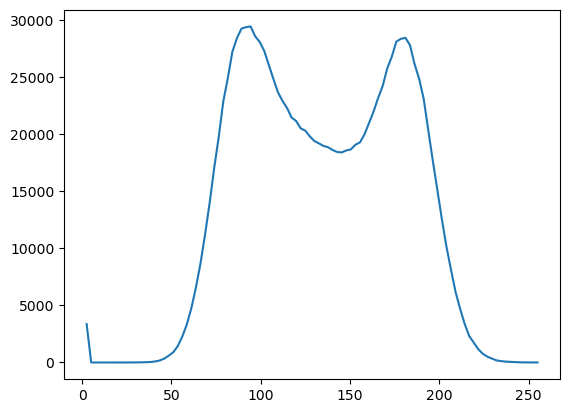

In [96]:
tfs.display.plot_im_histogram(im8)
# im8 = TS.current_im8 # uncomment this line to get the original back display (raw at original grayscale range)
# im8 = tfs.display.adjust_image_contrast(im8,20,200)

#### update training set if labels are ok or clear the current canvas by re-running the cell above if not
automatically updates the stored label image on the disk

In [97]:
# same as above

label_set = canvas.get_image_data()

test = TS.current_truth.copy()

test[np.bitwise_and(label_set[:,:,0]>0,np.bitwise_xor(label_set[:,:,0]>0,label_set[:,:,1]>0))] = 1
test[label_set[:,:,1]>0] = 2
test[label_set[:,:,2]>0] = 4 #order of 4&3 flipped for legacy reasons (existing training labels)
test[np.bitwise_and(label_set[:,:,0]>0,label_set[:,:,1]>0)] = 3

TS.current_truth = test.copy()
imageio.imsave(TS.current_truthpath, TS.current_truth)

#### inspect labels and training progress
can be sometimes useful

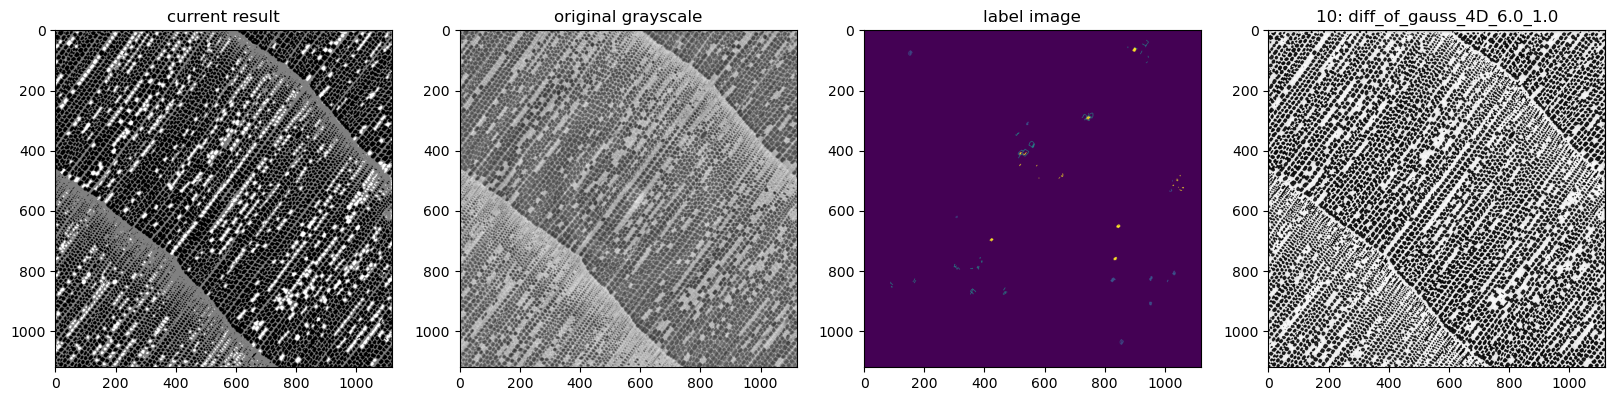

In [98]:
# same as above

fig, axes = plt.subplots(1,4, figsize=(20,10))
axes[0].imshow(TS.current_result, 'gray', interpolation=None)
axes[0].set_title('current result')
axes[1].imshow(TS.current_im8, 'gray', interpolation=None)
axes[1].set_title('original grayscale')

# TS.current_diff_im = TS.current_im-TS.current_first_im
# TS.current_diff_im = TS.current_diff_im/TS.current_diff_im.max()*255
# axes[2].imshow(-TS.current_diff_im)#,vmin=6e4)
# axes[3].imshow(im8old, 'gray')
# axes[3].imshow(TS.current_first_im, 'gray')
axes[2].imshow(TS.current_truth, interpolation=None)
axes[2].set_title('label image')
if TS.current_computed:
    axes[3].imshow(TS.current_feat_stack_full[:,:,i], 'gray', interpolation=None)
    axes[3].set_title(str(i)+': '+IF.combined_feature_names[i])
else:
    axes[3].imshow(TS.current_result, 'gray', interpolation=None)
    axes[3].set_title('current result')
# for ax in axes:
    # ax.set_xticks([])
    # ax.set_yticks([])

#### train!

In [99]:
TS.train_slice()

training and classifying


#### revise feature importance to decide on omiting a few to make calculation more efficient
TODO implementation to be done

Text(0, 0.5, 'importance')

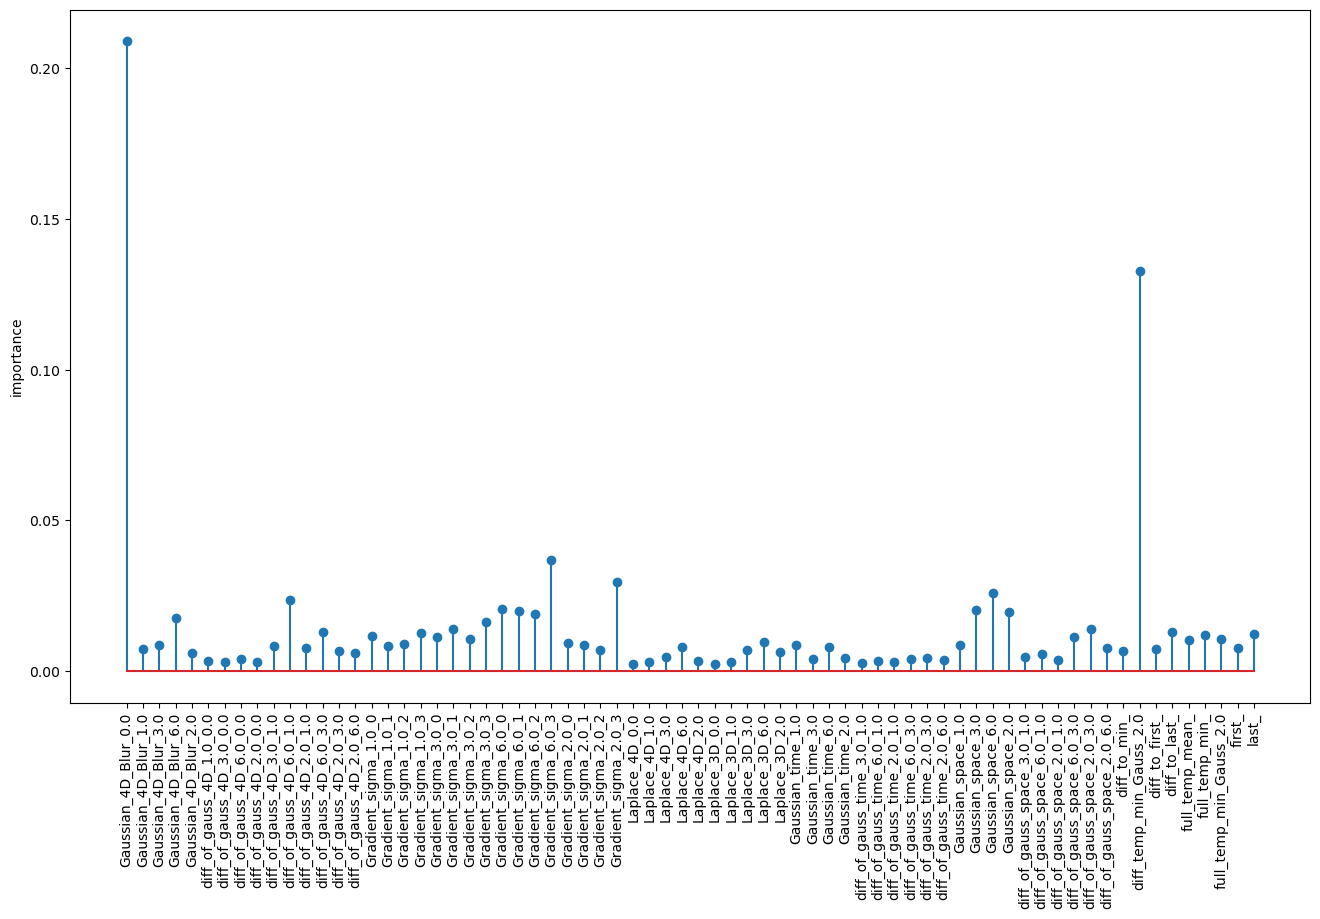

In [100]:
# TODO consider reduced feature stack
plt.figure(figsize=(16,9))
# plt.stem(np.array(IF.combined_feature_names)[feature_ids], TS.clf.feature_importances_,'x')
plt.stem(np.array(IF.combined_feature_names), TS.clf.feature_importances_,'x')
plt.xticks(rotation=90)
plt.ylabel('importance') 

In [101]:
# use date in front of git sha for easier tracking
date = str(datetime.datetime.now().date())
pickle.dump(TS.training_dict, open(os.path.join(training_path, date+'_git_sha_'+pytrain_git_sha+'_training_dict.p'),'wb'))
pickle.dump(TS.combined_feature_names, open(os.path.join(training_path, date+'_git_sha_'+pytrain_git_sha+'_feature_names.p'),'wb'))

In [102]:
date+'_git_sha_'+pytrain_git_sha

'2025-06-28_git_sha_08f3df6'

#### Save classifier

In [103]:
clf = TS.clf
pickle.dump(clf, open(os.path.join(training_path,  date+'_git_sha_'+pytrain_git_sha+'_clf.p'),'wb'))

In [56]:
TS.training_dict.keys()

dict_keys(['label_image_y_632_time_113_.tif', 'label_image_z_103_time_95_.tif', 'label_image_y_922_time_15_.tif', 'label_image_z_720_time_39_.tif', 'label_image_y_887_time_43_.tif', 'label_image_y_1002_time_40_.tif', 'label_image_z_1002_time_2_.tif', 'label_image_z_659_time_63_.tif', 'label_image_z_364_time_103_.tif', 'label_image_y_554_time_89_.tif', 'label_image_y_837_time_60_.tif', 'label_image_z_900_time_78_.tif', 'label_image_y_352_time_74_.tif', 'label_image_y_731_time_3_.tif', 'label_image_y_3_time_108_.tif', 'label_image_z_711_time_61_.tif', 'label_image_y_342_time_2_.tif', 'z_636_time_32_'])

### Select features to keep to reduce feature stack
throw away 50% of the features by using the median of the feature importance  
the yarn sample showed no susceptible redcution of segmentation quality

In [54]:
importance_median = np.median(TS.clf.feature_importances_)
feature_ids = TS.clf.feature_importances_>importance_median

In [57]:
features_to_use = []
for i in range(len(feature_ids)):
    if feature_ids[i]:
        features_to_use.append(IF.combined_feature_names[i])
    

In [58]:
# TODO write txt instead of pickle dump

093c73c


In [59]:
features_to_use

['Gaussian_4D_Blur_0.0',
 'Gaussian_4D_Blur_1.0',
 'Gaussian_4D_Blur_6.0',
 'diff_of_gauss_4D_6.0_0.0',
 'diff_of_gauss_4D_6.0_1.0',
 'Gradient_sigma_1.0_0',
 'Gradient_sigma_1.0_1',
 'Gradient_sigma_1.0_3',
 'hessian_sigma_1.0_00',
 'hessian_sigma_1.0_01',
 'hessian_sigma_1.0_11',
 'Gradient_sigma_3.0_3',
 'hessian_sigma_3.0_00',
 'hessian_sigma_3.0_01',
 'hessian_sigma_3.0_02',
 'hessian_sigma_3.0_03',
 'hessian_sigma_3.0_11',
 'hessian_sigma_3.0_33',
 'Gradient_sigma_6.0_0',
 'Gradient_sigma_6.0_1',
 'Gradient_sigma_6.0_2',
 'Gradient_sigma_6.0_3',
 'hessian_sigma_6.0_01',
 'hessian_sigma_6.0_03',
 'hessian_sigma_6.0_11',
 'hessian_sigma_6.0_12',
 'hessian_sigma_6.0_13',
 'hessian_sigma_6.0_22',
 'hessian_sigma_6.0_23',
 'hessian_sigma_6.0_33',
 'Gradient_sigma_2.0_0',
 'Gradient_sigma_2.0_3',
 'hessian_sigma_2.0_00',
 'hessian_sigma_2.0_01',
 'hessian_sigma_2.0_02',
 'hessian_sigma_2.0_11',
 'hessian_sigma_2.0_13',
 'Gaussian_time_0.0',
 'Gaussian_time_1.0',
 'Gaussian_time_6.0',
 

#### Save classifier

In [67]:
clf = TS.clf
pickle.dump(clf, open(os.path.join(training_path,  date+'_git_sha_'+pytrain_git_sha+'_clf.p'),'wb'))

## Segmentation

### load classifier


In [56]:
date+'_git_sha_'+pytrain_git_sha

'2025-06-26_git_sha_59a9df3'

In [118]:
prefix = '2025-05-27_git_sha_1712925'
clf = pickle.load(open(os.path.join(training_path, prefix+'_clf.p'),'rb'))
# clf.n_jobs = 40 #threads to be used for classifier. more is faster but needs more RAM, default is all available, tune if you get memory issues

In [119]:
feat = TS.feat_data['feature_stack']
feat_idp = TS.feat_data['feature_stack_time_independent']

### figure out good dimensions for peacewise segmentation
the chunks contain the entire time series --> makes no sense to split in time  
take the two biggest dimensions an don't split along the smallest spatial dimension --> saves one loop if you get away with it  
TODO: automate somehow

In [120]:
def round_up(val, dec=1):
    rval = np.round(val, dec)
    if rval < val:
        rval = rval+10**(-dec)
    rval = np.round(rval, dec) # to get rid of floating point uncertainties
    return rval

def calculate_part(part):
    if type(part) is not np.ndarray:
        fut = client.scatter(part)
        fut = fut.result()
        fut = fut.compute()
        part = fut
    return part

def get_the_client_back(client):
    try:
        client.restart()
    except:
        client = reboot_client(client)
    if not len(client.cluster.workers)>1:   
        client = reboot_client(client)
    return client

In [121]:
dim1 = 72#better use multiple of chunk size !?  <-- tune this parameter to minimize imax, jmax and the size of the result

# shp = feat.shape[:-1]
shp = shp_raw

# aspect ratio 
dimsize = np.sort(shp[:-1] )
aspect = round_up(dimsize[-1]/dimsize[-2])

# check length of loops to process entire dataset, estimate size of obtained sub-feature to avoid out-of-memory issues

dim2 = int(round_up(aspect*dim1, 0))
jmax = int(round_up(dimsize[-2]/dim1, 0))
imax = int(round_up(dimsize[-1]/dim2, 0))

i = imax -2
j = jmax -2
print(imax,jmax)
feat[i*dim1:(i+1)*dim1,:,j*dim2:(j+1)*dim2,:,:]

10 10


<xarray.DataArray 'feature_stack' (x: 72, y: 720, z: 202, time: 120,
                                   feature: 105)> Size: 1TB
dask.array<getitem, shape=(72, 720, 202, 120, 105), dtype=float64, chunksize=(36, 36, 36, 120, 1), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) int64 576B 576 577 578 579 580 581 ... 642 643 644 645 646 647
  * y        (y) int64 6kB 0 1 2 3 4 5 6 7 8 ... 712 713 714 715 716 717 718 719
  * z        (z) int64 2kB 1616 1617 1618 1619 1620 ... 1813 1814 1815 1816 1817
  * time     (time) int64 960B 0 1 2 3 4 5 6 7 ... 113 114 115 116 117 118 119
  * feature  (feature) <U27 11kB 'Gaussian_4D_Blur_0.0' ... 'diff_to_last_'

In [122]:
# segs = np.zeros(feat.shape[:4], dtype=np.uint8)
# segs = pickle.load(open(os.path.join(training_path, 'segs.p'),'rb')

In [123]:
training_path_sample

'/home/esrf/rofische/data_robert/Tomcat_2/R_m4_33_050_2'

In [124]:
piecepath = os.path.join(os.path.join(training_path_sample, 'segmentation_pieces')) #TODO: use the training path and not the temppath

restart_i = 0
restart_j = 0  #replace with the iterations you coudl reach before dask crashed
# get from the written files the restart coordinates
if os.path.exists(piecepath):
    ij_mat = np.zeros((imax,jmax), dtype=bool)
    for filename in os.listdir(piecepath):
        i = int(filename.split('_')[2])
        j = int(filename.split('_')[4])
        ij_mat[i,j] = True
        restart_i = int(np.min(np.argmin(ij_mat, axis=0)))
        restart_j = int(np.max(np.argmin(ij_mat, axis=1)))

print(restart_i, restart_j)

0 0


In [ ]:
# restart_i = 0
# restart_j = 14

# elapsed walltime: subprocess.check_output(['squeue','-u', 'fische_r']).decode().strip().split(' ')[-8]

# piecepath = os.path.join(os.path.join(temppath, 'segmentation_pieces'))
if not os.path.exists(piecepath):
    os.mkdir(piecepath)

for i in range(restart_i,imax):
    print(str(i+1)+'/'+str(imax))
    start_j = 0
    if i == restart_i:
        start_j = restart_j
    for j in range(start_j,jmax):
        print(j)
        part = feat[i*dim1:(i+1)*dim1,:,j*dim2:(j+1)*dim2,:,:] 
        part_idp = feat_idp[i*dim1:(i+1)*dim1,:,j*dim2:(j+1)*dim2,:]  
        if 0 in part.shape:
            print('hit the edge (one dimension 0), ignore')
            continue
        part = calculate_part(part)
        client = get_the_client_back(client)
        part_idp = calculate_part(part_idp)
        client = get_the_client_back(client)
        
        part_idp = np.stack([part_idp]*shp[-1], axis=-2)[:,:,:,0,:,:] #expand in time, a bit ugly, could maybe more elegant
        part = np.concatenate([part, part_idp], axis = -1)
        del part_idp # drop the time independent part, is this garbage collected?

        shp_orig = part.shape
        num_feat = part.shape[-1]  
        part = part.reshape(-1,num_feat)

        seg = clf.predict(part).astype(np.uint8)

        # put segs together when all calculated
        seg = seg.reshape(shp_orig[:4])

        pickle.dump(seg, open(os.path.join(piecepath, 'seg_i_'+str(i)+'_j_'+str(j)+'_.p'), 'wb'))

1/10
0


In [273]:
print('You got until i',i,'& j',j)


You got until i 0 & j 0


### piece segmentation back together

In [ ]:
segs = np.zeros(shp_raw, dtype=np.uint8)

for filename in os.listdir(piecepath):
    i = int(filename.split('_')[2])
    j = int(filename.split('_')[4])
    ### not sure if this switch cases are necessary
    seg = pickle.load(open(os.path.join(piecepath, filename),'rb'))
    if i < imax-1 and j < jmax-1:
        segs[i*dim1:(i+1)*dim1,:,j*dim2:(j+1)*dim2,:] = seg
    elif not i < imax-1 and j < jmax-1:
        segs[i*dim1:,:,j*dim2:(j+1)*dim2,:] =  seg
    elif not j < jmax-1 and i < imax-1:
        segs[i*dim1:(i+1)*dim1,:,j*dim2:,:] =  seg
    else:
        segs[i*dim1:,:,j*dim2:,:] = seg
    

### save result to disk when full volume has been processed

In [ ]:
# TODO: include metadata in segmented nc

shp = segs.shape
segdata = xr.Dataset({'segmented': (['x','y','z','timestep'], segs),
                     't_utc': ('timestep', t_utc),
                     'time': ('timestep', time)},
                               coords = {'x': np.arange(shp[0]),
                               'y': np.arange(shp[1]),
                               'z': np.arange(shp[2]),
                               'timestep': np.arange(shp[3]),
                               'feature': TS.combined_feature_names}
                     )
segdata.attrs = data.attrs.copy()
segdata.attrs['pytrain_git'] = pytrain_git_sha

In [ ]:
segpath = os.path.join(training_path_sample, sample+'_segmentation.nc')

In [ ]:
segdata.to_netcdf(segpath)